In [1]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# replace tqdm imported by any other module with tqdm.notebook
import sys
import tqdm
from tqdm.notebook import tqdm
sys.modules["tqdm"].tqdm = tqdm
sys.modules["tqdm.tqdm"] = tqdm
import ipywidgets as widgets # check if this is installed to make normal tqdm work inside the notebook

import os
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input

import numpy as np
import cv2

from art.estimators.classification import KerasClassifier

from art.attacks.evasion import SpatialTransformation
from art.attacks.evasion import FastGradientMethod

from art.defences.trainer import AdversarialTrainer

# from art.utils import load_mnist
from art.utils import load_dataset

#this is what makes the plots transparent in notebooks
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
# sn.set() #this changes the style of all plots, and imshow shows up wrong
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.externals import joblib

import time
import platform
import subprocess
import shutil
import load10_temp as ltemp

try:
    import tensorflow as tf
    # tf.config.run_functions_eagerly(False)
    tf.compat.v1.disable_eager_execution()
except:
    print("Failed to disable tensorflow eager execution")

Using TensorFlow backend.


In [2]:
img_size = 224

render_util_folder = os.getcwd()
if (platform.system() == "Windows"):
    blender_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\blender-2.78c-windows64" 
    dataset_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\greebles-generator-master\Greebles_3DS_10"
else:
    blender_folder = r"/home/ec1018/projects/blender-2.78c-linux-glibc219-x86_64"
    dataset_folder = r"/home/ec1018/projects/Greebles_3DS_10"

render_folder = os.path.join(os.getcwd(), "greebles_10") #reduced dataset of 10

# Delete folder - comment and uncomment as you need
# if os.path.exists(render_folder) and os.path.isdir(render_folder):
#     shutil.rmtree(render_folder)
    
if not os.path.isdir(dataset_folder):
    raise OSError(2, 'No such directory', str(dataset_folder))
if not os.path.exists(os.path.join(render_util_folder, 'render.py')):
    raise OSError(2, 'render.py not found', str(render_util_folder))

render_script = os.path.join(render_util_folder, 'render.py')

# Find the correct version of blender depending on the OS
if (platform.system() == "Windows"):
    blender_exec = os.path.join(blender_folder, 'blender.exe')
else:
    blender_exec = os.path.join(blender_folder, 'blender')
    
if not os.path.exists(os.path.join(blender_folder, blender_exec)):
    raise OSError(2, 'Blender executable not found', str(blender_folder))

# If you want to split command automatically
# import shlex; shlex.split("/bin/prog -i data.txt -o \"more data.txt\"")
# https://janakiev.com/blog/python-shell-commands/


set_mode = 'specific_all'
set_type = 'specific_angle'
#####################################
# Generate training set
blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                    '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                    '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', '0', '-zr', '0'])

# Move training set to folder                    
source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
ltemp.move_to_folder(source_folder, os.path.join(source_folder, "train"))

In [3]:
# Step 1: Get training set

(x_train, y_train) = ltemp.load_dataset_temp("train", source_folder)
x_train = np.array(x_train, dtype='float64')
y_train = np.array(y_train, dtype='float32')

print(x_train.shape)
print(y_train.shape)
y_train

(10, 224, 224, 1)
(10, 10)


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [4]:
# # Debug
# a = 8
# plt.imshow(x_train[a])
# true_label = np.argwhere(y_train[a] == 1).flatten()
# plt.title("{number}: {label}".format(label=true_label, number=a), fontsize=15, color='#ba5e27')
# plt.show()

246.0
23.0
ModeResult(mode=array([64.]), count=array([42113]))
---------
247.0
24.0
ModeResult(mode=array([64.]), count=array([41539]))
---------
244.0
23.0
ModeResult(mode=array([64.]), count=array([42649]))
---------
243.0
25.0
ModeResult(mode=array([64.]), count=array([42833]))
---------
245.0
25.0
ModeResult(mode=array([64.]), count=array([41727]))
---------
246.0
25.0
ModeResult(mode=array([64.]), count=array([41587]))
---------
246.0
24.0
ModeResult(mode=array([64.]), count=array([43002]))
---------
244.0
0.0
ModeResult(mode=array([64.]), count=array([42753]))
---------
246.0
23.0
ModeResult(mode=array([64.]), count=array([42988]))
---------
246.0
22.0
ModeResult(mode=array([64.]), count=array([42709]))
---------
247.0
24.0
246.0
24.0


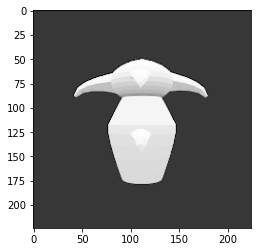

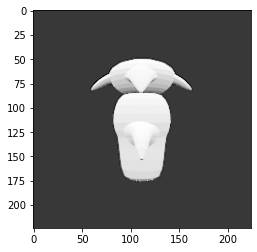

train1: [64.]
train2: [64.]
test: 0.25098039215686274


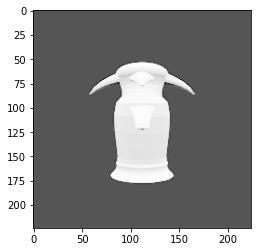

In [5]:
# for sample in x_train:
#     sample[sample == 64.0] = 1.0

from scipy import stats
for i in x_train:
    print(np.max(i))
    print(np.min(i))
    print(stats.mode(i,axis=None))
    print('---------')

colormap = 'Greys_r'
# colormap = 'GnBu'
# colormap = 'viridis'
i1 = 1
i2 = 6
print(np.max(x_train[i1]))
print(np.min(x_train[i1]))
print(np.max(x_train[i2]))
print(np.min(x_train[i2]))

plt.imshow(x_train[i1][:,:,0], cmap=colormap)
# plt.imshow(x_train[i1], cmap=colormap)
plt.show()
plt.imshow(x_train[i2][:,:,0], cmap=colormap)
# plt.imshow(x_train[i2], cmap=colormap)
plt.show()

import cv2
from PIL import Image
im_test_path = r"greebles_10\greebles_tf-specific_all\specific_angle\train\f4_41_lamps_000.png"
im_test_path = os.path.join(os.getcwd(), "greebles_10","greebles_tf-specific_all","specific_angle","train","f4_41_lamps_000.png")

# im_test = cv2.imread(im_test_path,0)
# im_test = np.float64(im_test)
im_test = np.array(Image.open(im_test_path).convert('L'), dtype='float64')
im_test *= (1.0/255)

test_color_bg_idx = [40,40]
print("train1:", x_train[i1][test_color_bg_idx[0], test_color_bg_idx[1]])
print("train2:", x_train[i2][test_color_bg_idx[0], test_color_bg_idx[1]])
print("test:", im_test[test_color_bg_idx[0], test_color_bg_idx[1]])

plt.imshow(im_test, cmap=colormap)
plt.show()
# print(im_test.shape)
# a = (x_train[i2][:,:,0] == im_test)
# print(np.where(a == False))

In [6]:
# Put all the different angles in a dictionary to access individually later
all_test = {}

y_rot = 0
# extra = "upsidedown"; y_rot = 180

test_set_gen_params = [-90, 90, 1]
# test_set_gen_params = [85, 90, 1]

try:
    test_set_name = "greebles10_{}_{}_{}_{}_{}.npy".format(extra,
                    test_set_gen_params[0], test_set_gen_params[1], test_set_gen_params[2], img_size)
except NameError:
    test_set_name = "greebles10_test_{}_{}_{}_{}.npy".format(
                    test_set_gen_params[0], test_set_gen_params[1], test_set_gen_params[2], img_size)

test_set_path = os.path.join(source_folder, test_set_name)

if not (os.path.isfile(test_set_path)):
    # Generate test set
    for z in range(test_set_gen_params[0], test_set_gen_params[1] + 1, test_set_gen_params[2]):

        blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                            '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                            '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', str(y_rot), '-zr', str(z)])

        # Move training set to folder                    
        source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
        ltemp.move_to_folder(source_folder, os.path.join(source_folder, "test"))

        print(z, end=", ")
        (x_test, y_test) = ltemp.load_dataset_temp("test", source_folder)
        x_test = np.array(x_test, dtype='float64')
        y_test = np.array(y_test, dtype='float32')

        all_test[str(z)] = (x_test, y_test)
    
    # Save the concatenated set after loop
#     np.save(test_set_path, all_test) #not working with higher res images
    joblib.dump(all_test, test_set_path)


# all_test = np.load(test_set_path, allow_pickle=True).item()
all_test = joblib.load(test_set_path)
print("\n", all_test["90"][0].shape)


 (10, 224, 224, 1)


In [7]:
print(all_test.keys())

dict_keys(['-90', '-89', '-88', '-87', '-86', '-85', '-84', '-83', '-82', '-81', '-80', '-79', '-78', '-77', '-76', '-75', '-74', '-73', '-72', '-71', '-70', '-69', '-68', '-67', '-66', '-65', '-64', '-63', '-62', '-61', '-60', '-59', '-58', '-57', '-56', '-55', '-54', '-53', '-52', '-51', '-50', '-49', '-48', '-47', '-46', '-45', '-44', '-43', '-42', '-41', '-40', '-39', '-38', '-37', '-36', '-35', '-34', '-33', '-32', '-31', '-30', '-29', '-28', '-27', '-26', '-25', '-24', '-23', '-22', '-21', '-20', '-19', '-18', '-17', '-16', '-15', '-14', '-13', '-12', '-11', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', 

In [8]:
# Calculate mean for each channel
np.mean(x_train, axis=(0,1,2))

array([84.15459184])

In [9]:
(x_test, y_test) = np.copy(all_test['80'][0]), np.copy(all_test['80'][1])
# IMPORTANT NOTE: The test set is not being normalized here, only training

# Normalize images, try scaling with the stdev. subtract mean and mult by a factor. or just leave them as is.
# x_train *= (1.0/x_train.max())
# x_test *= (1.0/x_test.max())

x_train *= (1.0/255)
x_test *= (1.0/255)

print(np.max(x_train))
print(np.min(x_train))
print(np.max(x_test))
print(np.min(x_test))

class_names = ltemp.get_class_names()
print(class_names)
# print(class_names['train'] == class_names['test'])
print("Classes for confusion matrix")
for idx, c in enumerate(class_names['train']):
    print("{}: {}".format(idx, c))

0.9686274509803922
0.0
0.9686274509803922
0.08627450980392157
{'train': array(['f-1', 'f-2', 'f-3', 'f-4', 'f-5', 'm-1', 'm-2', 'm-3', 'm-4',
       'm-5'], dtype='<U3')}
Classes for confusion matrix
0: f-1
1: f-2
2: f-3
3: f-4
4: f-5
5: m-1
6: m-2
7: m-3
8: m-4
9: m-5


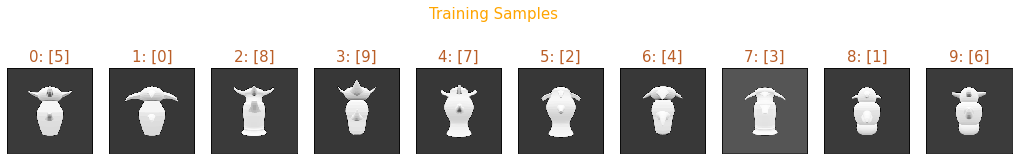

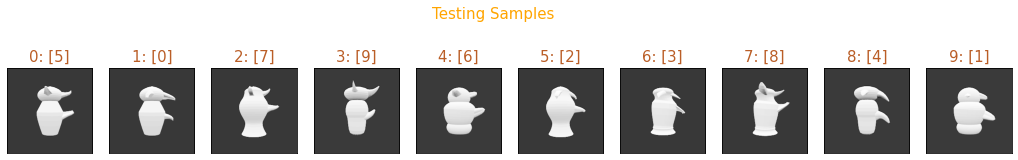

In [10]:
# Step 1.1: Visualize training set and labels
fig, axes = plt.subplots(1,10, figsize=(18,3))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i][:,:,0], interpolation='nearest', cmap=colormap)
    # ax.imshow(x_train[i], interpolation='nearest', cmap=colormap)
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(1,10, figsize=(18,3))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i][:,:,0], cmap=colormap)
    # ax.imshow(x_test[i], cmap=colormap)
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

In [11]:
def to_rgb(img):
    '''https://github.com/keras-team/keras/issues/11208'''
    # img = img * 255
    # img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    
    # img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.float32)
    img_rgb = np.asarray(np.dstack((img, img, img)))
    return img_rgb

def set_to_rgb(t_set):
    rgb_list = []
    #convert x_train data to rgb values
    for i in range(len(t_set)):
        rgb = to_rgb(t_set[i])
        rgb_list.append(rgb)
        #print(rgb.shape)
        rgb_arr = np.stack([rgb_list],axis=4)
    rgb_arr_to_3d = np.squeeze(rgb_arr, axis=4)
    return rgb_arr_to_3d

In [12]:
x_train = set_to_rgb(x_train)
x_test = set_to_rgb(x_test)
print(x_train.shape)
print(x_test.shape)
np.max(x_train[0])

(10, 224, 224, 3)
(10, 224, 224, 3)


0.9647058823529412

In [13]:
# Debug
print(np.amin(x_train))
print(np.amax(x_train))
print(np.amin(x_test))
print(np.amax(x_test))
# a = preprocess_input(x_train)
# display(a[0][30,30,:])
# display(x_train[0][30,30,:])

0.0
0.9686274509803922
0.08627450980392157
0.9686274509803922


In [14]:
display(np.argwhere(np.isinf(x_train)))
display(np.argwhere(np.isinf(x_test)))
display(np.argwhere(np.isnan(x_train)))
display(np.argwhere(np.isnan(x_test)))

array([], shape=(0, 4), dtype=int64)

array([], shape=(0, 4), dtype=int64)

array([], shape=(0, 4), dtype=int64)

array([], shape=(0, 4), dtype=int64)

In [15]:
# x_train = preprocess_input(x_train)
# x_test = preprocess_input(x_test)

In [16]:
def get_test_angle_normal(all_test, angle):
    (x_test, y_test) = np.copy(all_test[str(angle)][0]), np.copy(all_test[str(angle)][1])
    x_test *= (1.0/255)
    x_test = set_to_rgb(x_test)
    return (x_test, y_test)


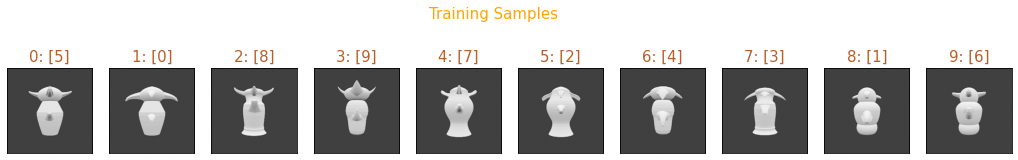

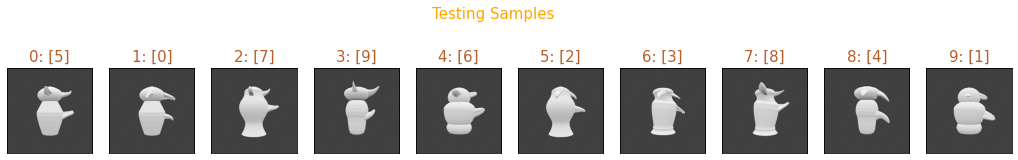

In [17]:
# Step 1.1: Visualize training set and labels
fig, axes = plt.subplots(1,10, figsize=(18,3))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(1,10, figsize=(18,3))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i])
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

In [18]:
# Step 2: Create the model
from keras import backend as K
K.clear_session()

# base_model = VGG16(weights=None, include_top=False, input_shape= (img_size, img_size, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape= (img_size, img_size, 3))
# for layer in base_model.layers:
#     layer.trainable=False

print(base_model.summary())
head_model = base_model.output
head_model = Flatten()(head_model)
head_model = Dense(4096, activation="relu")(head_model)
head_model = Dense(4096, activation="relu")(head_model)
head_model = Dense(10, activation="softmax")(head_model)
model = Model(base_model.input, head_model)
model.summary()

# learning_rate = 0.000001
learning_rate = 0.00001

model.compile(
    # loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.00001), metrics=["accuracy"] # original, best imagenet
    # loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.000007), metrics=["accuracy"] # best none
    loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Nadam(lr=0.00001), metrics=["accuracy"] # best none
    # loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.RMSprop(lr=0.00001), metrics=["accuracy"] # best imagenet
    # loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.RMSprop(lr=0.000003), metrics=["accuracy"] # best none
)







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
____

In [19]:
# Step 3: Create the ART classifier
min_pixel_value = 0.0
max_pixel_value = 1.0
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
# Step 4: Train the ART classifier

# classifier.fit(x_train, y_train, batch_size=64, nb_epochs=30)
classifier.fit(x_train, y_train, batch_size=10, nb_epochs=200, shuffle=True,
    validation_data=get_test_angle_normal(all_test, angle=45)
    )

all_acc = {}

=======================] - 0s 117ms/step - loss: 2.2157 - acc: 0.4000 - val_loss: 2.2598 - val_acc: 0.2000
Epoch 52/200
1/1 [==============================] - 0s 117ms/step - loss: 2.2161 - acc: 0.5000 - val_loss: 2.2501 - val_acc: 0.2000
Epoch 53/200
1/1 [==============================] - 0s 117ms/step - loss: 2.2503 - acc: 0.1000 - val_loss: 2.2418 - val_acc: 0.1000
Epoch 54/200
1/1 [==============================] - 0s 118ms/step - loss: 2.1990 - acc: 0.5000 - val_loss: 2.2354 - val_acc: 0.1000
Epoch 55/200
1/1 [==============================] - 0s 118ms/step - loss: 2.2968 - acc: 0.0000e+00 - val_loss: 2.2249 - val_acc: 0.2000
Epoch 56/200
1/1 [==============================] - 0s 118ms/step - loss: 2.1793 - acc: 0.4000 - val_loss: 2.2078 - val_acc: 0.1000
Epoch 57/200
1/1 [==============================] - 0s 117ms/step - loss: 2.1288 - acc: 0.5000 - val_loss: 2.2059 - val_acc: 0.1000
Epoch 58/200
1/1 [==============================] - 0s 117ms/step - loss: 2.0626 - acc: 0.2000 - 

Accuracy on benign test examples: 60.0%

[0 1 2 3 4 5 6 7 8 9] 10
[1 2 4 5 6 9] 6
Accuracy Score : 0.6
Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1
           2       0.33      1.00      0.50         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         1

    accuracy                           0.60        10
   macro avg       0.43      0.60      0.48        10
weighted avg       0.43      0.60      0.48        10

/home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` wi

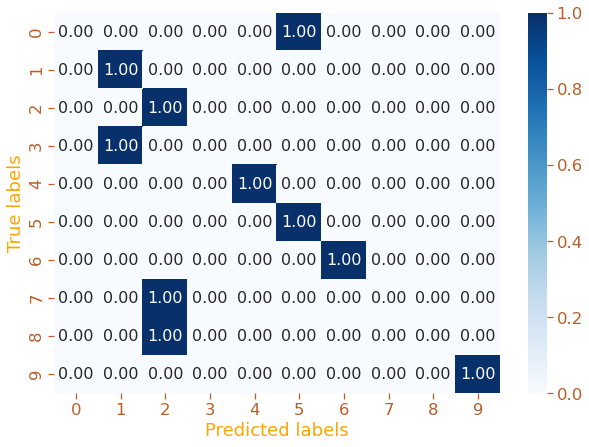

In [21]:
# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
all_acc['nat'] = accuracy * 100

print()

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7))

with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues

plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [22]:
classifier._model.history.history.keys()

/home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

10/10 [==============================] - 0s 2ms/step
test set stats: ['loss', 'acc'] -> [2.236893653869629, 0.6000000238418579]
2
8


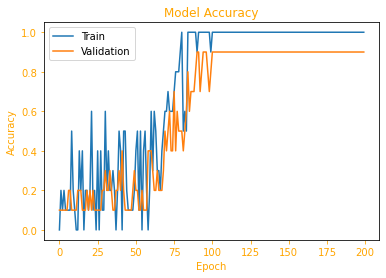

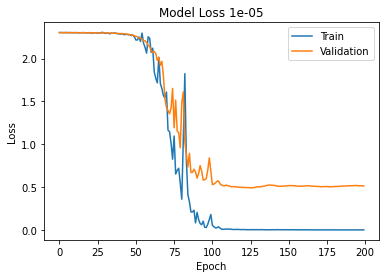

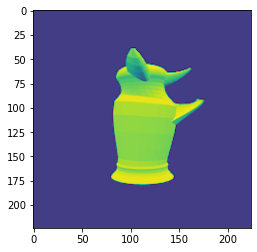

In [23]:
# You can call the underlying model variable at it gives the same results as the wrapped one above
# print(classifier._model.history.history)

print("test set stats: {} -> {}".format(classifier._model.metrics_names, classifier._model.evaluate(x_test, y_test)))

# Get all the wrong predictions to see where the classifier messed up
wrong_predictions = np.argwhere((np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) == False)
# print(wrong_predictions)
# predictions[wrong_predictions]

# First misclassified sample (index 7, should be a 9)
single_sample = np.expand_dims(x_test[7], axis=0)
print(np.argmax(classifier.predict(single_sample)))
# print(classifier._model.predict_classes(single_sample))
print(np.argmax(y_test[7]))

legend = ['Train']

plt.figure()
ax = plt.gca()
plt.plot(classifier._model.history.history['acc'])
if 'val_acc' in classifier._model.history.history.keys():
    plt.plot(classifier._model.history.history['val_acc'])
    legend.append('Validation')
plt.ylabel('Accuracy', color="orange")
plt.xlabel('Epoch', color="orange")
plt.legend(legend, loc='best')
plt.title('Model Accuracy', color="orange")
ax.tick_params(axis='x', colors="orange")
ax.tick_params(axis='y', colors="orange")

plt.figure()
plt.plot(classifier._model.history.history['loss'])
if 'val_loss' in classifier._model.history.history.keys():
    plt.plot(classifier._model.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(legend, loc='best')
plt.title('Model Loss {}'.format(learning_rate))

plt.figure()
plt.imshow(x_test[7][:,:,0])
plt.show()

In [24]:
all_acc = {}
for k in all_test.keys():
    (x_test, y_test) = get_test_angle_normal(all_test, angle=k)
    # Calculate accuracy
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    all_acc[k] = accuracy
    print("Accuracy on {} degrees: {}%".format(k, accuracy * 100))

Accuracy on -90 degrees: 50.0%
Accuracy on -89 degrees: 50.0%
Accuracy on -88 degrees: 50.0%
Accuracy on -87 degrees: 50.0%
Accuracy on -86 degrees: 50.0%
Accuracy on -85 degrees: 50.0%
Accuracy on -84 degrees: 50.0%
Accuracy on -83 degrees: 50.0%
Accuracy on -82 degrees: 50.0%
Accuracy on -81 degrees: 50.0%
Accuracy on -80 degrees: 50.0%
Accuracy on -79 degrees: 50.0%
Accuracy on -78 degrees: 50.0%
Accuracy on -77 degrees: 50.0%
Accuracy on -76 degrees: 50.0%
Accuracy on -75 degrees: 50.0%
Accuracy on -74 degrees: 50.0%
Accuracy on -73 degrees: 50.0%
Accuracy on -72 degrees: 60.0%
Accuracy on -71 degrees: 60.0%
Accuracy on -70 degrees: 60.0%
Accuracy on -69 degrees: 60.0%
Accuracy on -68 degrees: 60.0%
Accuracy on -67 degrees: 60.0%
Accuracy on -66 degrees: 60.0%
Accuracy on -65 degrees: 60.0%
Accuracy on -64 degrees: 60.0%
Accuracy on -63 degrees: 60.0%
Accuracy on -62 degrees: 60.0%
Accuracy on -61 degrees: 70.0%
Accuracy on -60 degrees: 70.0%
Accuracy on -59 degrees: 70.0%
Accuracy

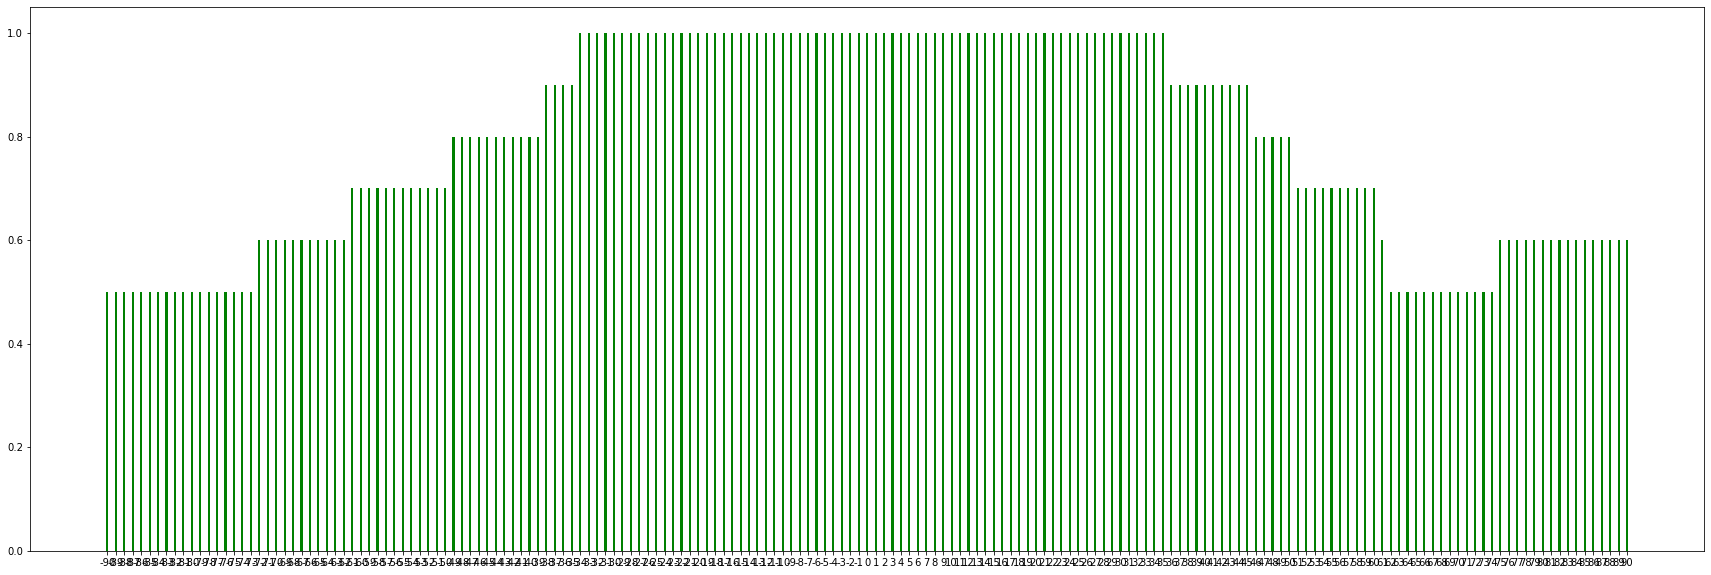

In [25]:
fig = plt.figure(figsize=(30,10))
plt.bar(all_acc.keys(), all_acc.values(), width = 0.25, color='g')
plt.show()

In [26]:
# Stop execution early
raise KeyboardInterrupt

/home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/tensorflow_core/contrib/learn/python/learn/learn_io/generator_io.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Container


KeyboardInterrupt: 

In [ ]:
# Step 6: Generate adversarial test examples

# Craft adversarial samples
print("Create adversarial attack")
attack = SpatialTransformation(classifier=classifier, max_translation=10.0, num_translations=1, max_rotation=30.0, num_rotations=1)
# attack = FastGradientMethod(classifier, eps=0.1)
print("Craft attack on training examples")
x_train_adv = attack.generate(x_train)
print("Craft attack test examples")
x_test_adv = attack.generate(x_test)

print(x_train_adv.shape)
print(x_test_adv.shape)

In [ ]:
# Step 6.1: Visualize adversarial samples
fig, axes = plt.subplots(3,10, figsize=(10,4), facecolor='None')
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train_adv[i][:,:,0])
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test_adv[i][:,:,0])
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Test Samples', fontsize=15, color='orange')

plt.show()

In [33]:
# classifier.save("model_224_rgb_none.h5", path=".")
classifier.save("model_224_rgb_imagenet.h5", path=".")

/home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples before AT: {}%".format(accuracy * 100))
all_acc['adv_before_AT'] = accuracy * 100

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7), facecolor='None')
with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [ ]:
# Step 8: Create adversarial trainer and perform adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=1.0)
adv_trainer.fit(x_train_adv, y_train, batch_size=64, nb_epochs=3)

In [ ]:
# Step 9: Evaluate new robustly trained classifier
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples after AT: {}%".format(accuracy * 100))
all_acc['adv_after_AT'] = accuracy * 100

print(all_acc)

In [ ]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))
# %matplotlib inline
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))

plt.figure(figsize=(10,7), facecolor='None')
# print(plt.style.available)
# plt.style.use('default')
with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    hm = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()
# dir(hm)
[(param, value) for param, value in plt.rcParams.items() if 'color' in param]